### Temporary file - I'll merge this into the isochrone file

The isochrone fit has indicated that there are a great deal of stars that the detection algorithm has picked up on that don't seem to be in the cluster - their B-V colours don't match with their expected computed V band magnitudes compared to the rest of the stars in the cluster.

As such, we'll need to find a way to get rid of these stars. One approach would to be play around with the threshold of the star detection algorithm, hoping that less background 'distractions' are picked up. However, this approach has its problems, in that it affects the detection of the stars *within* our cluster in an uneven manner.

We can foresee a situation where we lose more low mass stars within our cluster than high mass stars, whereas background stars that are sufficiently luminant as to be captured by the algorithm might still be shown on our HR diagram, even though their temperatures are far too blue for their magnitudes.

As such, we'll take a second approach. Given that our object is an open cluster (which should have uniform age), we'll use the isochrone as an authority on the open cluster's age and distance and get rid of any stars that don't fall near the isochrone on the HR diagram.

This can be done by Iterating over our stars and calculating the Cartesian distance to the closest point on the isochrone.

In [164]:
import numpy as np
import astropy
from astropy import units as u
import matplotlib.pyplot as plt 
from astropy.table import QTable
import warnings
from functools import partial
warnings.filterwarnings('ignore')


In [165]:
mags = QTable.read("obj_magnitudes.ecsv", format='ascii.ecsv')
index_to_id = [row['id'] for row in mags]

extinction = 1
reddening = extinction/3.1

px = mags['Bmag'] - mags['Vmag'] - reddening
py = mags['Vmag'] - extinction      



# IMPORT ISOCHRONES

In [166]:
# Code adapted from Girardi_UBVRI.ipynb on Moodle

class isochroneclass:
    def __init__(self):
        self.filename = "NULL                            "      # Relevant filename
        self.age = -99.0                                        # Age (log)
        self.m = []                                   # Star masses
        self.U = []                                   # Star U-band magnitudes
        self.B = []                                   # Star B-band magnitudes
        self.V = []                                   # Star V-band magnitudes
        self.R = []                                   # Star R-band magnitudes
        self.I = []                                   # Star I-band magnitudes


In [167]:
# Adapted from Girardi_UBVRI.ipynb on Moodle

fname = 'isochrones/output410618231006_1e6_to_15e6.dat'
isochrones = {}


with open(fname, "r") as f:
    lines = f.readlines()

    curr_age = -99.0

    # iterate through lines of data file and add relevant information to ic object
    for x in lines:
        if x[0] != '#':
            split_line = x.split()
            age = float(split_line[2])
            if age != curr_age:
                if curr_age > -99.0:
                    isochrones[curr_age] = ic
                ic = isochroneclass()               # create new ic class
                curr_age = age                    # update current age
                ic.age = curr_age                 # set age for new isochrone
            ic.m.append(float(split_line[5]))     # mass of star
            ic.U.append(float(split_line[28]))    # U-band magnitude
            ic.B.append(float(split_line[29]))    # B-band magnitude
            ic.V.append(float(split_line[30]))    # V-band magnitude
            ic.R.append(float(split_line[31]))    # R-band magnitude
            ic.I.append(float(split_line[32]))    # I-band magnitude

    isochrones[curr_age] = ic




In [168]:
offset = 12

In [169]:
nine_myr_ich = isochrones[6.95424]

bv = np.array(nine_myr_ich.B) - np.array(nine_myr_ich.V)
offsetV = np.array(nine_myr_ich.V) + offset



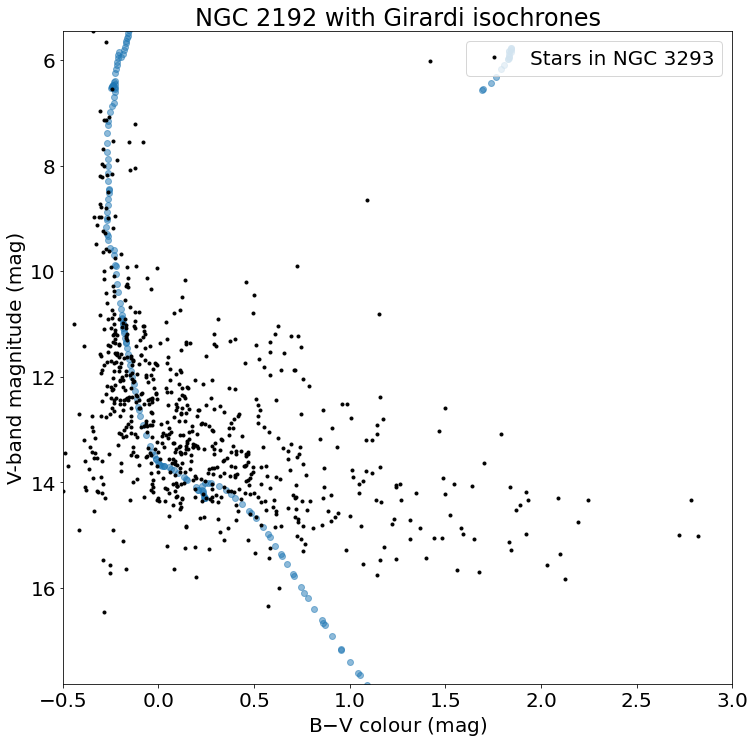

In [170]:
fig, ax = plt.subplots(figsize = (12,12))
plt.rcParams.update({'font.size': 20})
plt.plot(px, py, '.', color='black',label='Stars in NGC 3293',zorder=10)
plt.scatter(bv, offsetV, alpha=0.5)

plt.xlabel('B$-$V colour (mag)')
plt.ylabel('V-band magnitude (mag)')
plt.title('NGC 2192 with Girardi isochrones')


# set y-axis limits so we can see the stars
plt.ylim(min(py),max(py))
plt.xlim(-0.5,3)

# invert y-axis so brighter stars are at the top
ax.invert_yaxis()

plt.legend(loc='upper right')

plt.show()


## Filtration code

Given that the axes of our chart occupy different orders of magnitude with different scaling, we can't just use the Euclidean distance directly. It'll be far more sensitive to deviations from the isochrone in the magnitude value than the colour value. 

As such, we'll need to scale one of the domains to the other's domain such that we have a 'square' plot of some derived quantity with equal scaling to the other. Selecting this transformation factor is a qualitative process - we'll just have to pick it such that it feels 'right'.

We'll say that we're happy with the plots when the range of the colour axis is set to [-0.5, 3.0] and the V-band magnitude axis is set to [5.5, 18]. These don't have to be exact since our transformation doesn't 'cut' any data off, only stretches it.

We'll then scale our colour axis up to match the range of the V-band magnitude. It doesn't matter which we pick, but I'd rather work with larger values to minimise the impact of floating point errors. It's not a big deal.

In [171]:
colour_range = (-0.5, 3.0)
vmag_range = (5.5, 18)


def transform_colour(bv):
    # colour index's relative position between -0.5 and 3.0
    relative_position = (bv-colour_range[0])/(colour_range[1]-colour_range[0])
    # use relative position to calculate colour in vmag scale
    return relative_position*(vmag_range[1]-vmag_range[0]) + vmag_range[0]


We're working entirely with abstract derived quantities now, but they don't need to have meaning in order for us to define some threshold 'distance' from the isochrone.

Now we'll need to apply this x-coordinate transformation to both our stars and our isochrone.

In [172]:
px_t = list(map(transform_colour, px))
bv_t = list(map(transform_colour, bv))

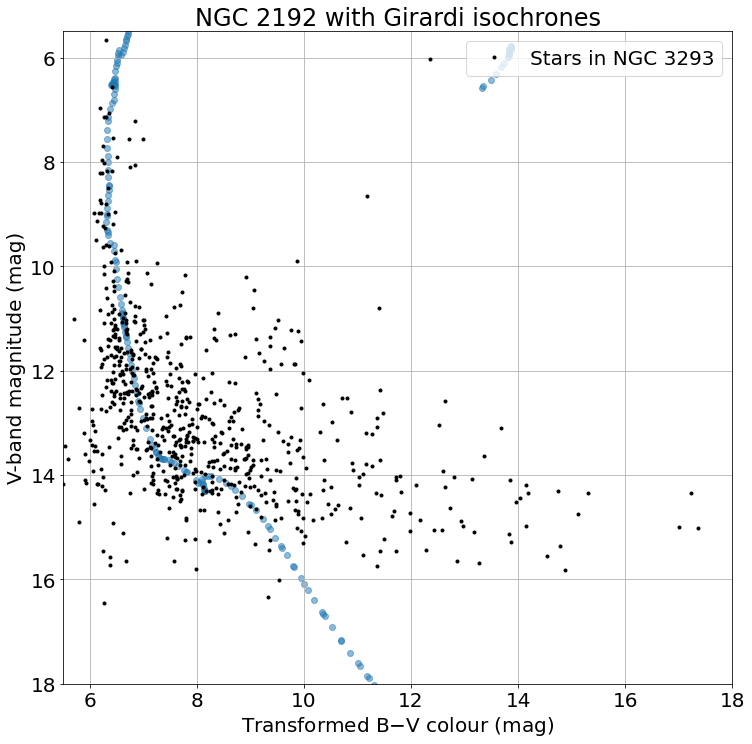

In [173]:
fig, ax = plt.subplots(figsize = (12,12))
plt.rcParams.update({'font.size': 20})
plt.plot(px_t, py, '.', color='black',label='Stars in NGC 3293',zorder=10)
plt.scatter(bv_t, offsetV, alpha=0.5)

plt.xlabel('Transformed B$-$V colour (mag)')
plt.ylabel('V-band magnitude (mag)')
plt.title('NGC 2192 with Girardi isochrones')


# set y-axis limits so we can see the stars
plt.ylim(vmag_range)
plt.xlim(vmag_range)

# invert y-axis so brighter stars are at the top
ax.invert_yaxis()

plt.legend(loc='upper right')
plt.grid(True)
plt.show()


We have our transformed coordinates. It doesn't matter that our v-band magnitude is upside down - the fact we're using a square grid now means that our Euclidean distance values will be valid.

Now let's define our distance calculation.

In [174]:
# calculates euclidean distance between two points
def euclid_dist(x1, y1, x2, y2):
    return np.linalg.norm(np.array([x2, y2])-np.array([x1, y1]))


# gets the minimum distance from a point to a list of points
def min_euclid_dist(xlist, ylist, single_x, single_y):
    dist = partial(euclid_dist, single_x, single_y)
    return min(map(dist, xlist, ylist))


In [175]:
# partially applied function that sets the xlist and ylist of our min_euclid_dist to the constant values of our isochrone
star_dist = partial(min_euclid_dist, bv_t, offsetV)

#sample distance to isochrone
star_dist(11, 16)

0.8968615232223607

For illustration, let's compute the distances for all the stars.

In [176]:
star_dists = list(map(star_dist, px_t, py))

In [177]:
star_dists[:10]

[0.3861619693414468,
 1.944997969870222,
 0.44425353182668675,
 0.8348690636529026,
 0.5222314584354598,
 0.5999856385203924,
 0.350931112081531,
 2.8046152784245875,
 0.4183862230364863,
 0.5878058009748307]

This looks good! Now comes the subjective part - experiementing with thresholds for what reasonable distances should look like. 

In [178]:
# returns the new px_t, py pairs of stars below the threshold, as well as indices of the stars that were above and thus removed
def exceeding_indices(px, py, threshold_dist):
    removed_stars = [idx for idx, tup in enumerate(zip(px_t, py)) if star_dist(tup[0], tup[1]) > threshold_dist]
    filtpx = [x for idx, x in enumerate(px) if idx not in removed_stars]
    filtpy = [y for idx, y in enumerate(py) if idx not in removed_stars]
    return removed_stars, filtpx, filtpy


In [179]:
threshold_1 = 1
threshold_2 = 2

In [180]:
removed_stars, filtpx_t, filtpy = exceeding_indices(px_t, py, threshold_1)
removed_stars_2, filtpx_t_2, filtpy_2 = exceeding_indices(px_t, py, threshold_2)

print(len(removed_stars))
print(len(removed_stars_2))

217
105


For a threshold of 1, we can plot the resulting HR diagram by filtering on px (our pre-transformation colours)

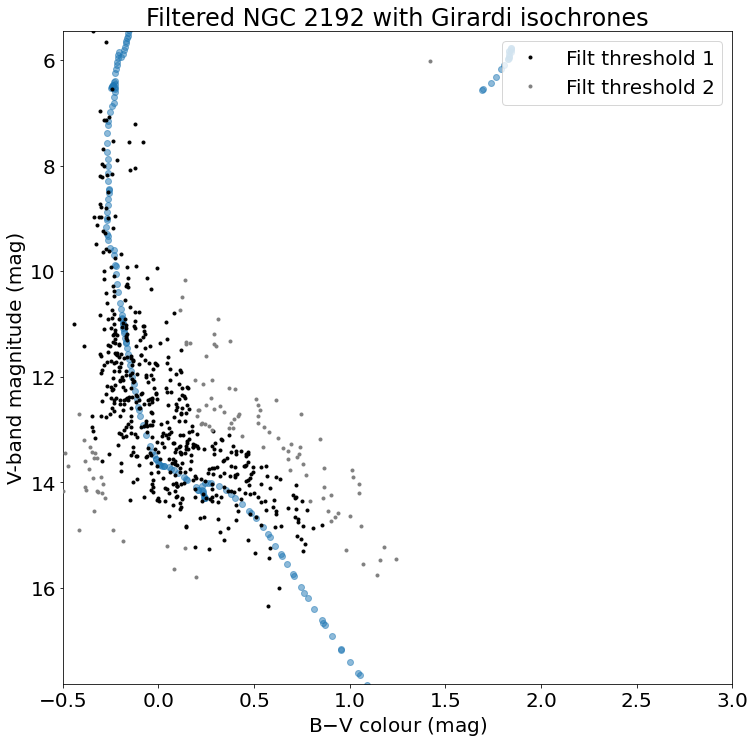

In [181]:
filtpx = [x for idx, x in enumerate(px) if idx not in removed_stars]


looser_filt = set(removed_stars) - set(removed_stars_2)
looser_filtpx = [x for idx, x in enumerate(px) if idx in looser_filt]
looser_filtpy = [y for idx, y in enumerate(py) if idx in looser_filt]



fig, ax = plt.subplots(figsize = (12,12))
plt.rcParams.update({'font.size': 20})
plt.plot(filtpx, filtpy, '.', color='black',label=f'Filt threshold {threshold_1}',zorder=10)
plt.plot(looser_filtpx, looser_filtpy, '.', color='grey',label=f'Filt threshold {threshold_2}',zorder=10)
plt.scatter(bv, offsetV, alpha=0.5)

plt.xlabel('B$-$V colour (mag)')
plt.ylabel('V-band magnitude (mag)')
plt.title('Filtered NGC 2192 with Girardi isochrones')


# set y-axis limits so we can see the stars
plt.ylim(min(py),max(py))
plt.xlim(-0.5,3)

# invert y-axis so brighter stars are at the top
ax.invert_yaxis()

plt.legend(loc='upper right')

plt.show()